# Notebook displaying usage of the three main functionalities of *ritme*

This notebook demonstrates how to use the three methods in `ritme` either through the [command line](#cli-example-usage) or in [a Python script](#python-api-example-usage). 

This demonstration uses example datasets from the [QIIME2 Moving Pictures tutorial](https://docs.qiime2.org/2024.10/tutorials/moving-pictures/). To ensure a quick run time for demonstration purposes only the Linear Regression trainable is trained in this notebook (variable `ls_model_types` in the respective experiment configuration files).

## Fetch data

To run the CLI and the Python API examples you first have to fetch the data by running the following commands from within this folder `experiments`:

`````
curl -L -o data/movpic_metadata.tsv \
  "https://data.qiime2.org/2024.10/tutorials/moving-pictures/sample_metadata.tsv"

curl -L -o data/movpic_table.qza \
  https://docs.qiime2.org/2024.10/data/tutorials/moving-pictures/table.qza

curl -L -o data/movpic_taxonomy.qza \
  https://docs.qiime2.org/2024.10/data/tutorials/moving-pictures/taxonomy.qza

curl -L -o data/movpic_tree.qza \
  https://docs.qiime2.org/2024.10/data/tutorials/moving-pictures/rooted-tree.qza
`````

## CLI example usage

Run the below commands from within this folder `experiments`:

````
ritme split-train-test \
  data_splits data/movpic_metadata.tsv data/movpic_table.qza \
  --seed 12

ritme find-best-model-config \
  ../config/example_linreg.json data_splits/train_val.pkl \
  --path-to-tax data/movpic_taxonomy.qza \
  --path-to-tree-phylo data/movpic_tree.qza \
  --path-store-model-logs ritme_example_logs

ritme evaluate-tuned-models \
  ritme_example_logs/example_linreg data_splits/train_val.pkl data_splits/test.pkl
````


You can find the trained best model objects (= best model with the best feature engineering method) in this path:

`{path-store-model-logs}/{config["experiment_tag"]}/*_best_model.pkl`

where 
* `path-store-model-logs`: is the parameter provided to `find-best-model-config`
* `config["experiment_tag"]`: is the experiment tag specified in the experiment config file (in this example in file `../config/example_linreg.json`)

Note the path is also printed upon running `find-best-model-config` under "Best model configurations were saved in".

You can now use the specified best model and create predictions on the train and test set in Python with:

```
import pandas as pd
import pickle

# paths saved train/test splits & best model we are interested in
path_to_train = "data_splits/train_val.pkl"
path_to_test = "data_splits/test.pkl"
path_to_best_linreg = "ritme_example_logs/example_linreg/linreg_best_model.pkl"

# read data
train_cli = pd.read_pickle(path_to_train)
test_cli = pd.read_pickle(path_to_test)

# read best linreg model
with open(path_to_best_linreg, "rb") as file:
    best_linreg_cli = pickle.load(file)

# perform prediction with best linreg model on test and train
test_predictions = best_linreg_cli.predict(test_cli, "test")
train_predictions = best_linreg_cli.predict(train_cli, "train")
```

## Python API example usage

In [1]:
import os

from ritme.evaluate_tuned_models import evaluate_tuned_models
from ritme.find_best_model_config import (
    _load_experiment_config,
    _load_phylogeny,
    _load_taxonomy,
    find_best_model_config,
    save_best_models,
)
from ritme.split_train_test import _load_data, split_train_test

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
######## USER INPUTS ########
# set experiment configuration path
model_config_path = "../config/example_linreg_py.json"

# define path to feature table, metadata, phylogeny, and taxonomy
path_to_ft = "data/movpic_table.qza"
path_to_md = "data/movpic_metadata.tsv"
path_to_phylo = "data/movpic_tree.qza"
path_to_tax = "data/movpic_taxonomy.qza"

# define train size
train_size = 0.8

# if you want to store the best models, define path where you want to store
# them, else set None
path_to_store_best_models = "ritme_example_logs/example_linreg_py/best_models"
######## END USER INPUTS #####

In [3]:
config = _load_experiment_config(model_config_path)

### Fetch, read & split data

In [4]:
md, ft = _load_data(path_to_md, path_to_ft)
print(md.shape, ft.shape)

(35, 8) (34, 770)


In [5]:
train_val, test = split_train_test(
    md,
    ft,
    group_by_column=config["group_by_column"],
    train_size=train_size,
    seed=config["seed_data"],
)

Train: (27, 778), Test: (7, 778)


/Users/adamova/Documents/projects/14_LM1/ritme/ritme/split_train_test.py:139: UserWarning: Provided feature table contains absolute instead of relative abundances. Hence, converting it to relative abundances...
  warnings.warn(


### Find best model config

In [6]:
tax = _load_taxonomy(path_to_tax)
phylo = _load_phylogeny(path_to_phylo)

best_model_dict, path_to_exp = find_best_model_config(
    config, train_val, tax, phylo, path_store_model_logs="ritme_example_logs"
)

(train_linreg pid=10674) /Users/adamova/miniforge3/envs/ritme/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.134e+02, tolerance: 2.483e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
(train_linreg pid=10674)   model = cd_fast.enet_coordinate_descent(


(train_linreg pid=10674) Train: (21, 9), Test: (6, 9)


(train_linreg pid=10693) /Users/adamova/miniforge3/envs/ritme/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.021e-02, tolerance: 2.483e-02
(train_linreg pid=10693)   model = cd_fast.enet_coordinate_descent(
2025-06-09 19:19:07,846	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/adamova/Documents/projects/14_LM1/ritme/experiments/ritme_example_logs/example_linreg_py/linreg' in 0.0148s.


(train_linreg pid=10693) Train: (21, 32), Test: (6, 32)


2025-06-09 19:19:07,858	INFO tune.py:1041 -- Total run time: 32.74 seconds (32.62 seconds for the tuning loop).


### Evaluate best models

,rmse_train,r2_train,rmse_test,r2_test
linreg,3.114752,0.082919,4.059532,-13.953895


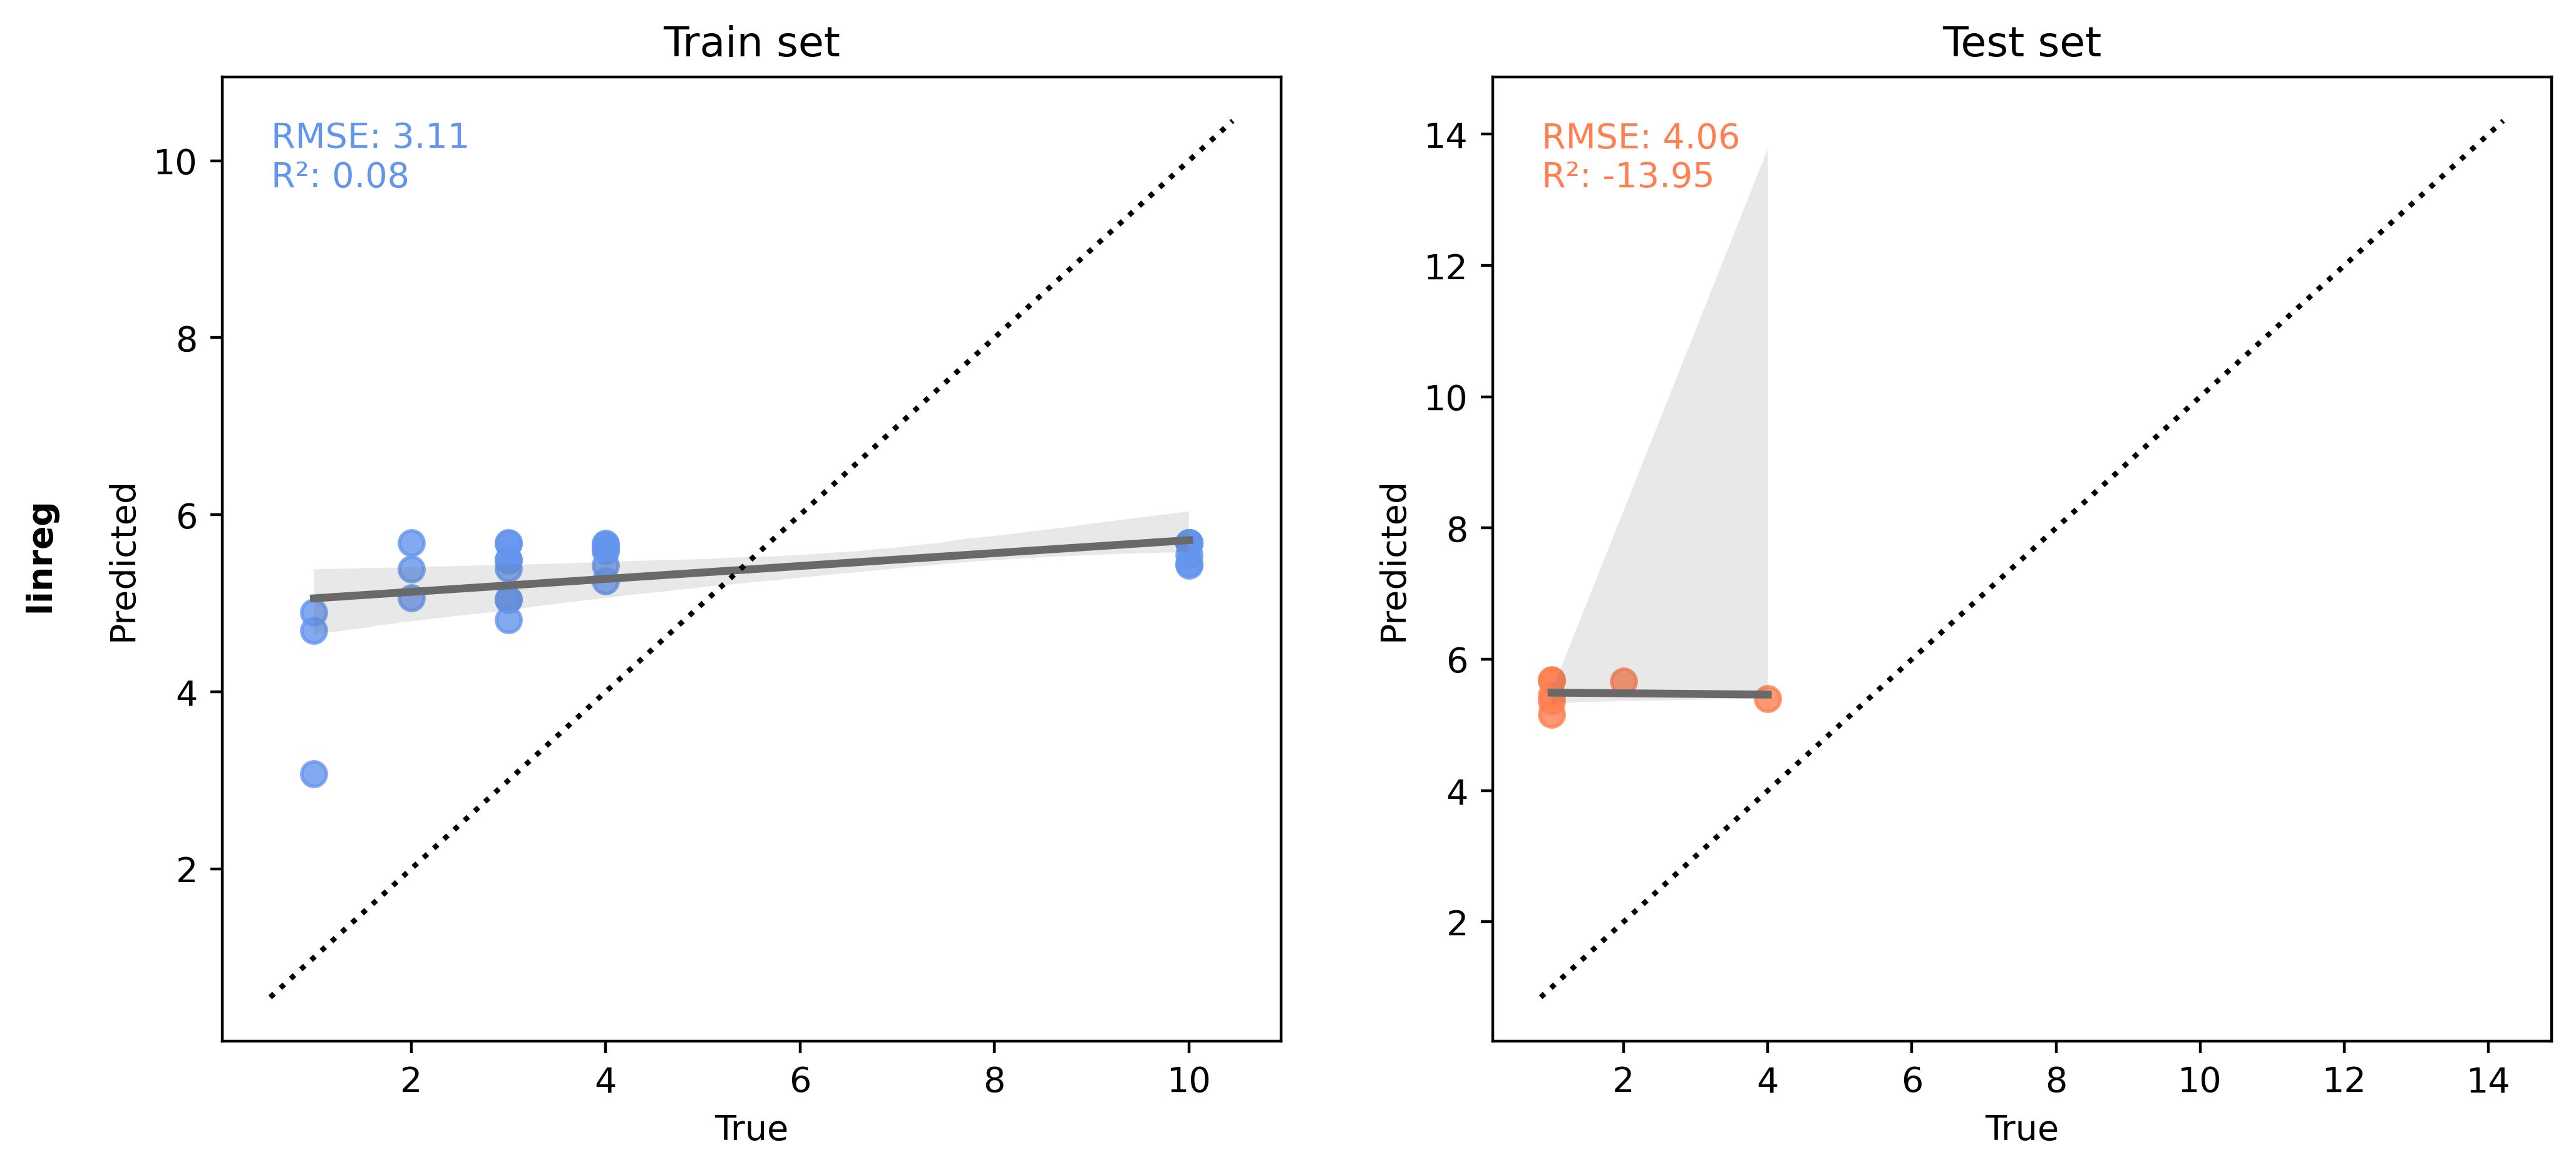

In [7]:
metrics, scatter = evaluate_tuned_models(best_model_dict, config, train_val, test)
metrics

### Extracting trained best models

#### Get best models for further usage

The best models are stored in Python dictionary best_model_dict with model_type as keys and `TunedModel` objects as values:

In [8]:
# get best linreg model
best_linreg_model = best_model_dict["linreg"]
best_linreg_model

#### Create predictions with best model

In [9]:
# perform prediction with best linreg model
test_predictions = best_linreg_model.predict(test, "test")
train_predictions = best_linreg_model.predict(train_val, "train")

#### Save all best models trained with Python API to disk

In [10]:
if path_to_store_best_models is not None:
    print(f"Saving best models to {path_to_store_best_models}...")
    if not os.path.exists(path_to_store_best_models):
        os.makedirs(path_to_store_best_models)

    save_best_models(best_model_dict, path_to_store_best_models)

Saving best models to ritme_example_logs/example_linreg_py/best_models...


#### Extract feature engineering properties of best model

In [11]:
best_linreg_model.data_config

{'data_aggregation': 'tax_class',
 'data_selection': 'abundance_topi',
 'data_selection_i': 1,
 'data_transform': 'alr',
 'data_alr_denom_idx': 0}